# Binary Classification Threshold Fine-tuning with Log Probs 

This notebook shows how to use logprobs for threshold fine-tuning for a binary classification problem

In [15]:
import sys
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from tqdm import tqdm
import pandas as pd
import os

from sklearn.metrics import precision_score, recall_score, f1_score

pd.options.mode.chained_assignment = None

# Add the project root to the path to allow importing from `part2`
sys.path.insert(0, os.path.abspath('.'))
from part2.logprobs_cli import get_logprobs

sns.set_theme(style="whitegrid")

In [16]:
# Read data
url = "https://raw.githubusercontent.com/justmarkham/pycon-2016-tutorial/master/data/sms.tsv"
df = pd.read_table(url, header=None, names=["label", "text"])
df["is_spam"] = (df["label"] == "spam").astype(int)
df = df[:1000]

In [17]:
# Caching helper functions

from diskcache import Cache
import hashlib
import json

cache = Cache("./logprob_cache")

def _make_cache_key(prompt: str, logprob_kwargs: dict) -> str:
    payload = {
        "prompt": prompt,
        "kwargs": logprob_kwargs,
    }
    dumped = json.dumps(payload, sort_keys=True)
    return hashlib.sha256(dumped.encode("utf-8")).hexdigest()


def get_logprobs_cached(prompt: str, **logprob_kwargs):
    key = _make_cache_key(prompt, logprob_kwargs)

    if key in cache:
        return cache[key]

    res = get_logprobs(prompt=prompt, **logprob_kwargs)
    cache[key] = res
    return res


In [18]:
spam_prompt_template = """You are classifying SMS messages.

Question: Is the following SMS message spam?

Answer with exactly one token: Yes or No.

Message:
{text}

Answer:
"""

def get_yes_no_logprobs(prompt, **logprob_kwargs):
    """
    Returns logp_yes, logp_no
    """
    res = get_logprobs_cached(
        prompt=prompt,
        top_k=5,
        temperature=0.0,
        **logprob_kwargs,
    )

    print(res.logprobs)
    lp = {t: p for t, p in res.logprobs.items()}
    # return lp.get("Yes", -float("inf")), lp.get("No", -float("inf"))
    return lp.get("Yes", None), lp.get("No", None)


In [19]:
def classify_spam(prompt_template, df, verbose=True, **logprob_kwargs):

    rows = []

    for _, row in df.iterrows():
        prompt = prompt_template.format(text=row["text"])
        lp_yes, lp_no = get_yes_no_logprobs(prompt, **logprob_kwargs)

        if lp_yes and lp_no:
            score = lp_yes - lp_no  # log-odds
        else:
            score = None

        if verbose:
            print(f"{prompt} -> yes={lp_yes}")

        rows.append({
            "score": score,
            "y": row["is_spam"]
        })

    return pd.DataFrame(rows)

scored_df = classify_spam(spam_prompt_template, df, model_id='llama3:8b', provider="ollama")

OrderedDict({'Yes': 0.9473329572535724, 'No': 0.05130428740641195, 'YES': 0.001021221373223399, 'NO': 0.00031950808183870994, 'yes': 1.0785701480798225e-05, '**': 2.7337861643661916e-06, 'Y': 1.5294956033711675e-06, '"Yes': 1.0849141020354052e-06, 'Answer': 1.0230797284349806e-06, ' YES': 4.844795103949693e-07})
You are classifying SMS messages.

Question: Is the following SMS message spam?

Answer with exactly one token: Yes or No.

Message:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Answer:
 -> yes=0.9473329572535724
OrderedDict({'No': 0.8879553312573193, 'Yes': 0.11008786602879002, 'NO': 0.0018790096162287413, 'YES': 6.364829724087795e-05, 'yes': 2.0407720041162956e-06, '"No': 1.749751537950282e-06, 'N': 1.635427220036185e-06, '**': 8.715659336724313e-07, 'no': 6.046841105436294e-07, 'Not': 5.826303552971708e-07})
You are classifying SMS messages.

Question: Is the following SMS message spam?

Answer with exactly 

In [20]:
# Naive prediction
df["pred_naive"] = (scored_df["score"] > 0).astype(int)

In [21]:
# Naive scores
precision_score(df["is_spam"], df["pred_naive"]), recall_score(df["is_spam"], df["pred_naive"]), f1_score(df["is_spam"], df["pred_naive"])

(0.33710407239819007, 0.9802631578947368, 0.5016835016835017)

In [22]:

def evaluate_thresholds(y_true, scores, thresholds):
    rows = []
    for t in thresholds:
        y_pred = (scores >= t).astype(int)
        rows.append({
            "threshold": t,
            "precision": precision_score(y_true, y_pred, zero_division=0),
            "recall": recall_score(y_true, y_pred, zero_division=0),
            "f1": f1_score(y_true, y_pred, zero_division=0),
            "positive_rate": y_pred.mean()
        })
    return pd.DataFrame(rows)

def plot_precision_recall_curve(df, scored_df, model_id, include_naive=True):

    thresholds = np.linspace(
        scored_df["score"].min(),
        scored_df["score"].max(),
        100
    )

    analysis = evaluate_thresholds(
        df["is_spam"].values,
        scored_df["score"].values,
        thresholds
    )

    if include_naive:
        naive_precision = precision_score(df["is_spam"], df["pred_naive"])
        naive_recall = recall_score(df["is_spam"], df["pred_naive"])
        print("NAIVE: ", naive_recall, naive_precision)
        plt.scatter(naive_recall, naive_precision, marker='o', color='red', s=100)

    plt.plot(analysis["recall"], analysis["precision"], marker=".", alpha=0.3)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    # plt.xlim([0.9, 1.0])
    plt.title(f"Precision–Recall Curve (LLM log-odds) Model={model_id}")
    plt.show()

    return analysis


NAIVE:  0.9802631578947368 0.33710407239819007


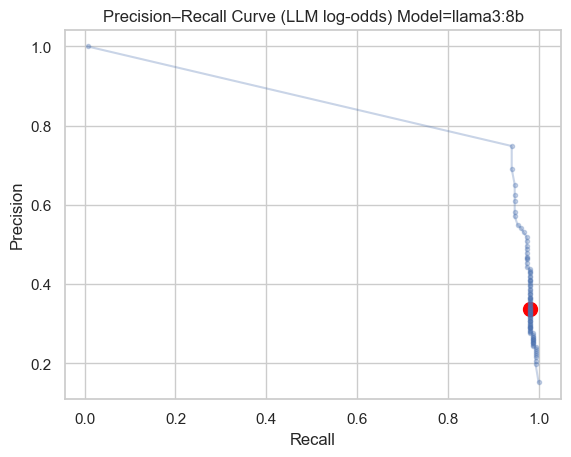

,threshold,precision,recall,f1,positive_rate
0,-0.999804,0.152000,1.000000,0.263889,1.000
1,-0.979608,0.198163,0.993421,0.330416,0.762
2,-0.959412,0.206566,0.993421,0.342016,0.731
3,-0.939216,0.215100,0.993421,0.353630,0.702
4,-0.919020,0.220760,0.993421,0.361244,0.684
...,...,...,...,...,...
95,0.918816,0.626087,0.947368,0.753927,0.230
96,0.939012,0.651584,0.947368,0.772118,0.221
97,0.959208,0.690821,0.940789,0.796657,0.207
98,0.979404,0.748691,0.940789,0.833819,0.191


In [23]:
plot_precision_recall_curve(df, scored_df, model_id="llama3:8b")

In [24]:
# You can also use it to surface ambiguous cases

df2 = pd.concat([df, scored_df], axis=1)
# 
df2['abs_score'] = abs(df2['score'])
df2.sort_values(by='abs_score', ascending=True)[:10]

,label,text,is_spam,pred_naive,score,y,abs_score
257,ham,Mmm so yummy babe ... Nice jolt to the suzy,0,1,0.006209,0,0.006209
246,ham,Too late. I said i have the website. I didn't ...,0,0,-0.009787,0,0.009787
546,ham,Then any special there?,0,0,-0.014149,0,0.014149
74,ham,U can call me now...,0,1,0.015287,0,0.015287
161,ham,Keep yourself safe for me because I need you a...,0,1,0.018175,0,0.018175
818,ham,Also are you bringing galileo or dobby,0,1,0.019076,0,0.019076
516,ham,S:)no competition for him.,0,0,-0.020632,0,0.020632
435,ham,You available now? I'm like right around hills...,0,0,-0.021425,0,0.021425
918,ham,"When people see my msgs, They think Iam addict...",0,1,0.026167,0,0.026167
488,ham,Dear reached railway. What happen to you,0,1,0.028867,0,0.028867


In [25]:
# Prompt engineering

prompt_template_cautious = """
You are a strict classifier.

Return Yes only if it contains
clear, explicit, and unambiguous indicators
of spam.

If there is any reasonable doubt, return No

Do not infer intent.
Do not guess.
Do not rely on weak signals.

Answer with only one token: "Yes" or "No".

Text:
{text}

Answer:
"""

scored_df = classify_spam(prompt_template_cautious, df, model_id='llama3:8b', provider="ollama")

OrderedDict({'No': 0.9468488509840354, 'Yes': 0.052997413985462906, 'NO': 0.00013857312988273395, 'YES': 5.7797585847668e-06, '"No': 2.4066520210390314e-06, '**': 1.5887865389191352e-06, '>No': 6.507768279714675e-07, '_No': 4.590574544016731e-07, 'yes': 3.8125493912905137e-07, '-No': 3.4495452210271844e-07})

You are a strict classifier.

Return Yes only if it contains
clear, explicit, and unambiguous indicators
of spam.

If there is any reasonable doubt, return No

Do not infer intent.
Do not guess.
Do not rely on weak signals.

Answer with only one token: "Yes" or "No".

Text:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Answer:
 -> yes=0.052997413985462906
OrderedDict({'No': 0.9999117135206009, 'NO': 4.516746058925575e-05, 'Yes': 4.106101324815513e-05, '"No': 9.285640252191247e-07, '**': 2.4310472450017003e-07, '>No': 1.9711305078532927e-07, '-No': 1.3148529167296997e-07, 'no': 1.2385423344348434e-07, '_No': 1.06609

In [26]:
df["pred_naive"] = (scored_df["score"] > 0).astype(int)
df['pred_naive']

0      0
1      0
2      1
3      0
4      0
      ..
995    0
996    0
997    0
998    0
999    0
Name: pred_naive, Length: 1000, dtype: int64

NAIVE:  0.9013157894736842 0.631336405529954


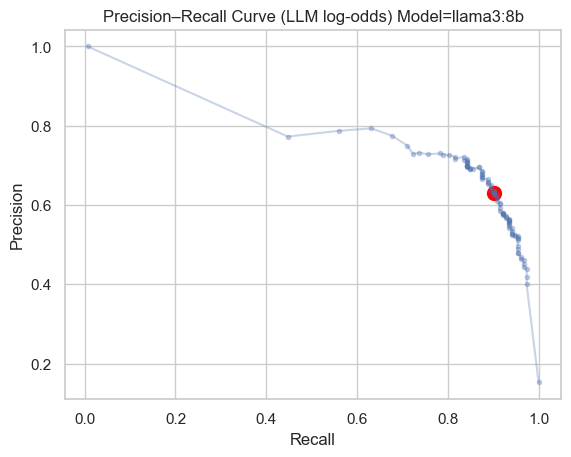

,threshold,precision,recall,f1,positive_rate
0,-0.999994,0.152457,1.000000,0.264578,0.997
1,-0.979794,0.400000,0.973684,0.567050,0.370
2,-0.959595,0.419263,0.973684,0.586139,0.353
3,-0.939396,0.439169,0.973684,0.605317,0.337
4,-0.919197,0.442771,0.967105,0.607438,0.332
...,...,...,...,...,...
95,0.918929,0.774436,0.677632,0.722807,0.133
96,0.939128,0.793388,0.631579,0.703297,0.121
97,0.959328,0.787037,0.559211,0.653846,0.108
98,0.979527,0.772727,0.447368,0.566667,0.088


In [ ]:
df["pred_naive"] = (scored_df["score"] > 0).astype(int)
plot_precision_recall_curve(df, scored_df, model_id="llama3:8b", include_naive=True)

OrderedDict({'No': 0.9927620861888201, 'Yes': 0.006951640135307203, 'NO': 0.0002785114549081385, 'YES': 2.0218437000116573e-06, '"No': 1.0591536330541845e-06, '>No': 6.655833980633513e-07, '**': 5.169518771756417e-07, 'no': 4.520283616043486e-07, '_No': 3.8869221806052667e-07, '-No': 2.7427471379316523e-07})

You are a VERY strict classifier.

Return Yes only if it contains very clear
clear, explicit, and unambiguous indicators
of spam.

If there is any reasonable doubt at all, you will return No

Do not infer intent.
Do not guess.
Do not rely on weak signals.
Only return "Yes" when you are absolutely certain!

Answer with only one token: "Yes" or "No".

Text:
Go until jurong point, crazy.. Available only in bugis n great world la e buffet... Cine there got amore wat...

Answer:
 -> yes=0.006951640135307203
OrderedDict({'No': 0.9999443879317315, 'NO': 5.168976826660087e-05, 'Yes': 2.6178753436586037e-06, '"No': 4.275871425797585e-07, 'no': 2.3034369585960063e-07, '>No': 1.8635806521884

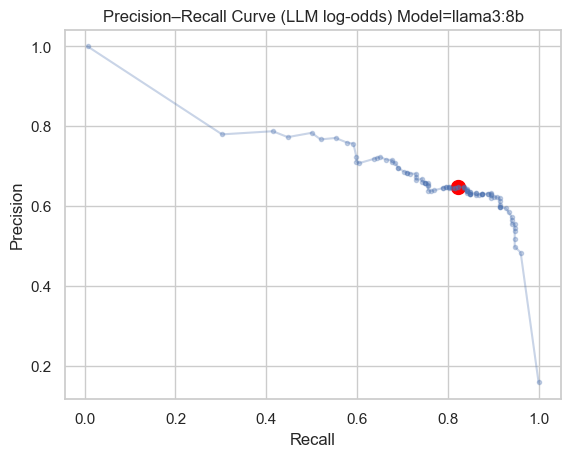

,threshold,precision,recall,f1,positive_rate
0,-0.999992,0.157840,1.000000,0.272646,0.963
1,-0.979799,0.483444,0.960526,0.643172,0.302
2,-0.959605,0.498270,0.947368,0.653061,0.289
3,-0.939412,0.517986,0.947368,0.669767,0.278
4,-0.919218,0.537313,0.947368,0.685714,0.268
...,...,...,...,...,...
95,0.918395,0.783505,0.500000,0.610442,0.097
96,0.938588,0.772727,0.447368,0.566667,0.088
97,0.958782,0.787500,0.414474,0.543103,0.080
98,0.978975,0.779661,0.302632,0.436019,0.059


In [29]:
# One more, very extreme classifier

prompt_template_cautious = """
You are a VERY strict classifier.

Return Yes only if it contains very clear
clear, explicit, and unambiguous indicators
of spam.

If there is any reasonable doubt at all, you will return No

Do not infer intent.
Do not guess.
Do not rely on weak signals.
Only return "Yes" when you are absolutely certain!

Answer with only one token: "Yes" or "No".

Text:
{text}

Answer:
"""

scored_df = classify_spam(prompt_template_cautious, df, model_id='llama3:8b', provider="ollama")

df["pred_naive"] = (scored_df["score"] > 0).astype(int)
plot_precision_recall_curve(df, scored_df, model_id="llama3:8b", include_naive=True)

In [30]:
# That makes me of other things we could do ...
# Erase an input token to see what effect it has on the log probs?

# Or just as a ranker ?

# ... calibration stuff?

## Scikit-LLM

Note that Scikit-LLM does not currently use logprobs, but it does have a few very useful constructs for classification. In particular it is completely sklearn compatible, so you can use it in familiar settings and even in existing sklearn `Pipeline` objects